# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import matplotlib.pyplot as plt
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

# Question 1

**Explain how you solve the model**

<function matplotlib.pyplot.show(close=None, block=None)>

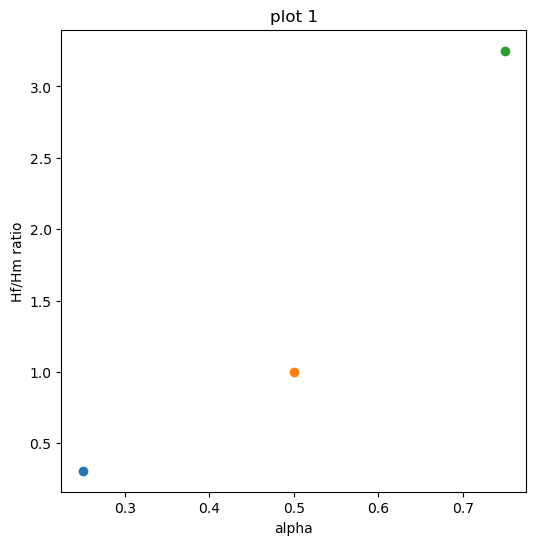

In [2]:
hsm = HouseholdSpecializationModelClass()

alpha_values = [0.25, 0.5, 0.75]

fig, ax = plt.subplots(figsize=(6, 6))

for alpha in alpha_values:
    hsm.par.alpha = alpha

    #solve the model
    opt = hsm.solve_discrete()

    #def the Hm/Hf ratio
    ratio = (opt.HF/opt.HM)

    #add data to scatterplot
    ax.scatter(alpha, ratio)

#define labels of the axes
ax.set_xlabel('alpha')
ax.set_ylabel('Hf/Hm ratio')
ax.set_title('plot 1')

#show plot
plt.show


c:\Users\luke-\Desktop\Uni\Semester 10 SS23 (Master)\Introduction to Programming\projects-2023-shashi-buhle\projects-2023-shashi-buhle\inauguralproject\HouseholdSpecializationModel.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*H**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


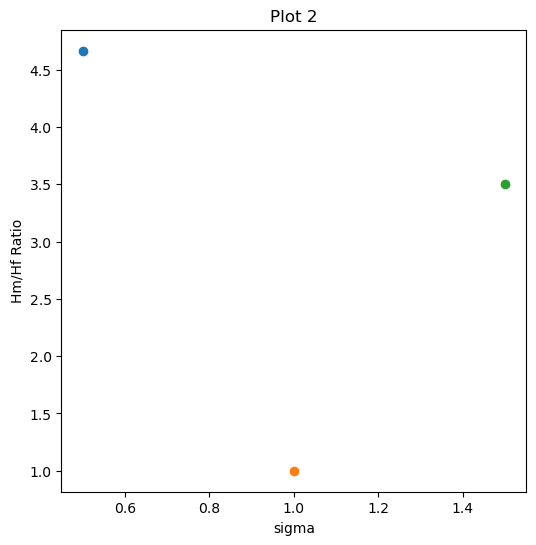

In [3]:
hsm = HouseholdSpecializationModelClass()

sigma_values = [0.5, 1.0, 1.5]
x = 0
fig, ax = plt.subplots(figsize=(6,6))

for sigma in sigma_values:
    hsm.par.sigma = sigma

    #solve the model
    opt = hsm.solve_discrete()

    #def the Hm/Hf ratio
    ratio = (opt.HF/opt.HM)

    #add data to the scatterplot
    ax.scatter(sigma, ratio)

#define the labels of the axes
ax.set_xlabel("sigma")
ax.set_ylabel("Hm/Hf Ratio")

ax.set_title("Plot 2")

#show plot
plt.show()


# Question 2

Explain your code and procedure

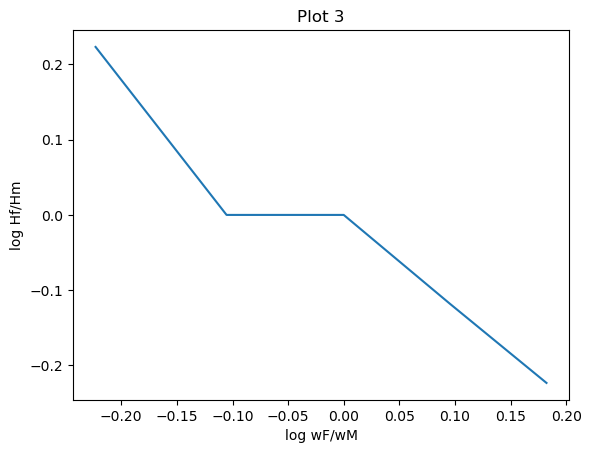

In [4]:
#get wages for male and female from the householdspecializationmodel
wF = hsm.par.wF_vec
wM = hsm.par.wM

#reset alpha and sigma values to a constant term
hsm.par.alpha = 0.5
hsm.par.sigma = 1

#create the log-wF/wM vector (find the optimal for each wF)
log_wages = []
log_ratio = []

for femalewages in wF:
    hsm.par.wF = femalewages
    opt = hsm.solve_discrete()
    log_ratio.append(np.log(opt.HF/opt.HM))
    log_wages.append(np.log(femalewages/wM))

#plot 
plt.plot(log_wages, log_ratio)
plt.xlabel("log wF/wM")
plt.ylabel("log Hf/Hm")
plt.title("Plot 3")
plt.show()

# Question 3

Explain your code and procedure

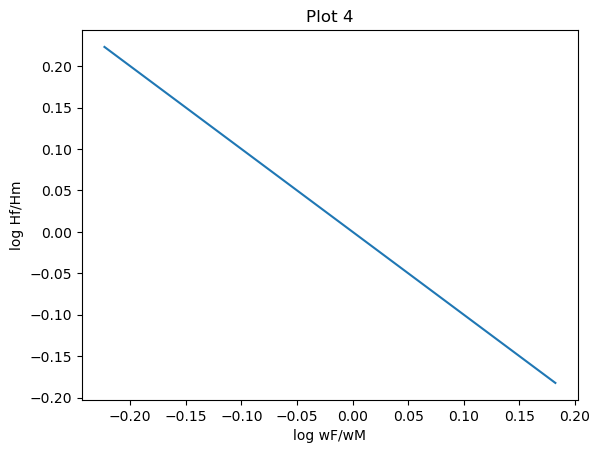

In [14]:
#get wages for male and female from the householdspecializationmodel
wF = hsm.par.wF_vec
wM = hsm.par.wM

#reset alpha and sigma values to a constant term
hsm.par.alpha = 0.5
hsm.par.sigma = 1

#create the log-wF/wM vector (find the optimal for each wF)
log_wages_continuous = []
log_ratio_continuous = []

for femalewages in wF:
    hsm.par.wF = femalewages
    opt = hsm.solve()
    log_ratio_continuous.append(np.log(opt.HF/opt.HM))
    log_wages_continuous.append(np.log(femalewages/wM))

#plot 
plt.plot(log_wages_continuous, log_ratio_continuous)
plt.xlabel("log wF/wM")
plt.ylabel("log Hf/Hm")
plt.title("Plot 4")
plt.show()

ADD CONCISE CONLUSION.